# Support vector machines

In [1]:
# import libraries

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, mutual_info_regression, f_regression, f_classif

from sklearn import preprocessing
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn import linear_model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn import model_selection

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

## Data pre-processing

In [4]:
# load training data

# load data from csv file
df_train_features = pd.read_csv ('train_features.csv')
df_train_labels = pd.read_csv('train_labels.csv')

# Load test data
df_test_features = pd.read_csv('test_features.csv')

### Sorting labels

In [5]:
df_train_labels = df_train_labels.sort_values('pid')
df_train_features = df_train_features.sort_values('pid')
df_test_features = df_test_features.sort_values('pid')

# Droping time
df_train_features = df_train_features.drop('Time', axis = 1)
df_test_features = df_test_features.drop('Time', axis = 1)

 ### Histogram of the output labels 

We should check for class imbalance.

In [ ]:
df_train_labels.hist()

# with PdfPages("./Results/Labels_histogram.pdf") as export_pdf:
#     for i in list(df_train_labels)[1:]:
#         df_train_labels.hist(column = i, bins = 100)
#         export_pdf.savefig()

One can see the class imbalance problem here. Other observations:
  * Heartrate, RRate, ABPm,  distribution is similar to a normal distribution
  * SpO2 is like a censored normal distribution. 
  * For all of the other features, class imbalance is an obvious problem.

A basic strategy that could be used here: Upsample both classes! Do the upsampling efficiently, not just replicating the datapoints

### Boxplot over features

In [ ]:
# data inspection: 
#############################################
# range of the provided data?
print(df_train_features.agg([min, max]))

# Boxplotting the data
# fig2, ax2 = plt.subplots()
# ax2.set_title('BUN')
# ax2.boxplot(df_train_features.iloc[:,5], notch=True)

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = df_train_features.iloc[:,1:])
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

# with PdfPages("./Results/Train_columns_boxplot.pdf") as export_pdf:
#     for i in list(df_train_labels)[1:]:
#         df_train_labels.hist(column = i, bins = 100)
#         export_pdf.savefig()

In [ ]:
# calculate the correlation matrix
corr = df_train_features.corr()

# plot the heatmap
plt.figure(figsize=(16, 16))
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, 
        vmin=-1, vmax=1, center=0, 
           cmap=sns.diverging_palette(20, 220, n=200))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Visualizing pattern of missing values

In [ ]:
# how much missing data? 
print("Percentage of missing values:")
print(df_train_features.isnull().sum(axis=0) / len(df_train_features))

msno.matrix(df_train_features)

# Plotting the correlation between the missing values
msno.heatmap(df_train_features)

### Train data pre-processing

In [6]:
# Which columns have less than a percent NA
NA_percent = 0.7
NA_percent_severe = 0.91

sel_features = df_train_features.isnull().sum(axis=0) < (NA_percent * df_train_features.shape[0])
inds = np.where(sel_features == True)

sel_features_2 = (df_train_features.isnull().sum(axis=0) < (NA_percent_severe * df_train_features.shape[0])) & (df_train_features.isnull().sum(axis=0) > (NA_percent * df_train_features.shape[0]))        
inds_2 = np.where(sel_features_2 == True)

sel_features_3 = df_train_features.isnull().sum(axis=0) > (NA_percent_severe * df_train_features.shape[0])
inds_3 = np.where(sel_features_3 == True)

vars_class1 = df_train_features.columns[inds[0]]
vars_class2 = df_train_features.columns[inds_2[0]]
vars_class3 = df_train_features.columns[inds_3[0]]
vars_classes = [vars_class1, vars_class2, vars_class3]

print("--------Our Columns are are: ",df_train_features.columns.drop("pid"))
print("--------Labels are: ", df_train_labels.columns)
print("********Var classes are: " ,vars_classes)

--------Our Columns are are:  Index(['Age', 'EtCO2', 'PTT', 'BUN', 'Lactate', 'Temp', 'Hgb', 'HCO3',
       'BaseExcess', 'RRate', 'Fibrinogen', 'Phosphate', 'WBC', 'Creatinine',
       'PaCO2', 'AST', 'FiO2', 'Platelets', 'SaO2', 'Glucose', 'ABPm',
       'Magnesium', 'Potassium', 'ABPd', 'Calcium', 'Alkalinephos', 'SpO2',
       'Bilirubin_direct', 'Chloride', 'Hct', 'Heartrate', 'Bilirubin_total',
       'TroponinI', 'ABPs', 'pH'],
      dtype='object')
--------Labels are:  Index(['pid', 'LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST',
       'LABEL_Alkalinephos', 'LABEL_Bilirubin_total', 'LABEL_Lactate',
       'LABEL_TroponinI', 'LABEL_SaO2', 'LABEL_Bilirubin_direct',
       'LABEL_EtCO2', 'LABEL_Sepsis', 'LABEL_RRate', 'LABEL_ABPm',
       'LABEL_SpO2', 'LABEL_Heartrate'],
      dtype='object')
********Var classes are:  [Index(['pid', 'Age', 'Temp', 'RRate', 'ABPm', 'ABPd', 'SpO2', 'Heartrate',
       'ABPs'],
      dtype='object'), Index(['Hgb', 'PaCO2', 'FiO2', 'Glucose', '

In [7]:
def aggregation_technique(dat, variables, pids, vars_classes):
    
    vars_class1 = vars_classes[0]
    vars_class2 = vars_classes[1]
    vars_class3 = vars_classes[2]
    
    aggregated_dataframe = []
    for pid in pids:
        # dataframe for this pid
        df = dat.loc[dat['pid'] == pid]
        calculated_features = []
        for var in variables:
            # how many NaN are in there for this variable
            data = df[var].tolist()
#             num_nan = np.count_nonzero(np.isnan(data))
            if var == "Age":
                calculated_features.append(data[0])
                
            elif var in vars_class1:
                calculated_features = calculated_features + data
#                 calculated_features.append(np.nanmean(data))
#                 calculated_features.append(np.nanstd(data))
                
            elif var in vars_class2:
                calculated_features.append(np.nanmean(data))
                calculated_features.append(np.nanstd(data))
                calculated_features.append(np.nanmin(data))
                calculated_features.append(np.nanmax(data))
            else:
                calculated_features.append(np.nanmean(data))
#                 calculated_features.append(np.nanstd(data))
                
        aggregated_dataframe.append(calculated_features)
        
    aggregated_dataframe = pd.DataFrame(aggregated_dataframe)
    return(aggregated_dataframe)
 
train_pids = df_train_features['pid'].unique()
df_train_agg_features = aggregation_technique(df_train_features, df_train_features.columns.drop("pid"), train_pids, vars_classes)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: All-NaN axis encountered
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: All-NaN axis encountered


In [8]:
print(df_train_agg_features.shape)
print(df_train_agg_features.columns)
print(df_train_agg_features)
# pd.DataFrame(data_train_scaled)

(18995, 133)
RangeIndex(start=0, stop=133, step=1)
        0    1     2     3    4     5     6     7     8     9    ...    123  \
0      34.0  NaN   NaN  12.0  NaN  36.0   NaN  38.0   NaN  37.0  ...  102.0   
1      86.0  NaN  31.8  32.0  NaN   NaN   NaN   NaN   NaN  36.0  ...  132.0   
2      66.0  NaN  34.6   8.0  NaN   NaN  37.0   NaN   NaN   NaN  ...  168.0   
3      66.0  NaN  53.8  32.0  1.8  38.0  38.0  38.0  38.0  38.0  ...  103.0   
4      42.0  NaN   NaN  18.0  NaN  36.0   NaN   NaN   NaN   NaN  ...  229.0   
...     ...  ...   ...   ...  ...   ...   ...   ...   ...   ...  ...    ...   
18990  52.0  NaN  25.8  11.0  1.7   NaN   NaN   NaN  36.0   NaN  ...    NaN   
18991  66.0  NaN   NaN  33.0  NaN   NaN   NaN   NaN  38.0   NaN  ...  172.0   
18992  44.0  NaN   NaN  15.0  NaN   NaN  38.0   NaN   NaN   NaN  ...   94.0   
18993  70.0  NaN   NaN   NaN  NaN  37.0   NaN   NaN   NaN   NaN  ...  113.0   
18994  60.0  NaN   NaN  13.0  NaN   NaN   NaN  37.0  37.0   NaN  ...  137.0   



In [ ]:
# print(train_pids[1:50])
# print(df_train_labels['pid'].tolist()[1:50])
print(np.nanmean(df_train_features['Age'].tolist()))
print(np.nanvar(df_train_features['Age'].tolist()))

In [ ]:
# # Run the imputer with a simple Random Forest estimator
# imp = IterativeImputer(RandomForestRegressor(n_estimators=5), max_iter=10, random_state=1)

# #perform filling
# df_train_agg_imputed_features = pd.DataFrame(imp.fit_transform(df_train_agg_features), columns=df_train_agg_features.columns)

In [9]:
# impute missing data points
#imp = SimpleImputer(strategy="mean")
imputer = KNNImputer(n_neighbors = 10)

df_train_agg_imputed_features = imputer.fit_transform(df_train_agg_features)

In [117]:
# scale the data
min_max_scaler = preprocessing.StandardScaler()
# standard_scalar = preprocessing.StandardScaler()

data_train_scaled = min_max_scaler.fit_transform(df_train_agg_imputed_features)

In [ ]:
# Visualizing the training data after imputing and aggregating

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = pd.DataFrame(data_train_scaled))
ax.set_xticklabels(
    list(df_train_features),
    rotation=90,
    horizontalalignment='right'
);

In [ ]:
# What is the correlation between the 
pd.DataFrame(data_train_scaled).corrwith(other = pd.DataFrame(df_train_agg_imputed_features), method = "spearman").transpose()

### PCA plot 

In [ ]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(data_train_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df_train_labels[[df_train_labels.columns[1]]]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA for label i', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[df_train_labels.columns[1]] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Test Data pre-processing

In [11]:
test_pids = df_test_features['pid'].unique()
df_test_agg_features = aggregation_technique(df_test_features, df_test_features.columns.drop("pid"),
                                             test_pids, vars_classes)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: All-NaN axis encountered
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: All-NaN axis encountered


In [ ]:
print(df_test_agg_features.isna().sum(axis = 0).tolist()[0:100])
print(df_train_agg_features.isna().sum(axis = 0).tolist()[0:100])

In [12]:
# impute missing data points
# should we impute it with the same imputer that we've used for train?

imputer = KNNImputer(n_neighbors= 10)
df_test_agg_imputed_features = imputer.fit_transform(df_test_agg_features)

In [118]:
# scale test data
min_max_scaler = preprocessing.StandardScaler()
data_test_scaled = min_max_scaler.fit_transform(df_test_agg_imputed_features)

In [14]:
pd.DataFrame(data_train_scaled).to_csv("./Results/dat_train_robust_scaled.csv", index = False)
pd.DataFrame(data_test_scaled).to_csv("./Results/dat_test_robust_scaled.csv", index = False)

In [4]:
# If want to run from here:
# data_train_scaled = pd.read_csv("./Results/dat_train_scaled.csv")
# data_test_scaled = pd.read_csv("./Results/dat_test_scaled.csv")

## Fit a model & Predict

### predict with support vector machine classification and use probabilities

In [10]:
print(list(set(df_test_features.pid))[1:30])
test_pids = df_test_features['pid'].unique()
print(test_pids[1:30])

[3, 5, 7, 9, 11, 12, 15, 16, 17, 19, 21, 22, 25, 28, 32, 36, 40, 42, 44, 46, 52, 58, 59, 60, 65, 66, 67, 68, 72]
[10001 10003 10004 10005 10008 10011 10017 10018 10019 10025 10028  1003
 10032 10033 10039  1004 10041 10042 10043 10046 10047  1005 10051  1006
 10060 10062 10063 10064 10067]


For feature  LABEL_BaseExcess
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  3.5min finished


[LibSVM]{'C': 20}
0.690690816442676
ROC AUC for feature LABEL_BaseExcess  :  0.7343770736473707


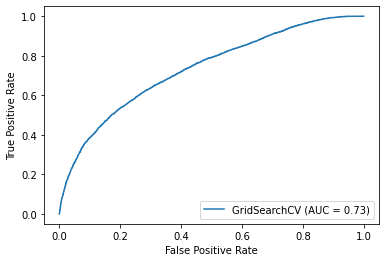

In [114]:
# first for the labels that have an output [0,1]
columns_1 = [test_pids]

from sklearn.utils import resample

for i in range(1, 12):
    
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_classif, mode ='k_best', param=50)
    train_features = pd.DataFrame(transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i]))
    print("For feature ", df_train_labels.columns[i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = pd.DataFrame(transformer.transform(data_test_scaled))

    
    #clf = BaggingClassifier(SVC(kernel = 'poly', degree = 5, class_weight = 'balanced', verbose = True, C = 10))
    clf_w = SVC(kernel = 'rbf', class_weight = {0:1,1:50}, verbose = 2)
    
    parameters = {'C':(0.1, 1, 10, 20)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 5,
                                        refit = True, scoring = 'roc_auc', verbose = 2,
                                       n_jobs=6, return_train_score = True)
    
#     weight_multiplier = 2
#     class_1 = df_train_labels.iloc[:,i] == 1
#     class_0 = df_train_labels.iloc[:,i] == 0

#     samples_count = int(np.sum(class_1)) * weight_multiplier
#     X = resample(train_features.loc[class_0,:],
#                     n_samples = samples_count, replace = False, random_state=0)
#     data_train = pd.concat([pd.DataFrame(X), pd.DataFrame(train_features.loc[class_1,:])], axis = 0)
#     data_label = ([0] * samples_count) + ([1] * int(samples_count / weight_multiplier))
#     print(data_train.shape)
#     print(len(data_label))

    clf.fit(train_features, df_train_labels.iloc[:,i])
#     clf.fit(train_features, labels)
    
#     print(clf.cv_results_)
    print(clf.best_params_)
    print(clf.best_score_)
    # compute probabilites as opposed to predictions
    #dual_coefficients = clf.dual_coef_    # do we have to normalize with norm of this vector ?
    
    distance_hyperplane = clf.decision_function(test_features)
    probability = np.empty(len(distance_hyperplane))
    for j in range(0, len(probability)):
        if distance_hyperplane[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplane[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplane[j]))
    columns_1.append(probability)

    
    distance_hyperplace_train = clf.decision_function(train_features)
    probability_train = np.empty(len(distance_hyperplace_train))
    for j in range(0, len(probability_train)):
        if distance_hyperplace_train[j] < 0:
            probability_train[j] = 1 - 1/(1 + math.exp(distance_hyperplace_train[j]))
        else:
            probability_train[j] = 1/(1 + math.exp(-distance_hyperplace_train[j]))
    
    tmp = roc_auc_score(y_score= probability_train, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    
    svc_disp = plot_roc_curve(clf, train_features, df_train_labels.iloc[:,i])
    plt.show()
    break

In [ ]:
# labels that have a real value
columns_2 = []
# from sklearn.kernel_ridge import KernelRidge

for i in range(12, 16):
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param =80)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)
    
    clf_w = SVR(kernel = 'rbf', cache_size = 6000)
# #     clf_w = NuSVR(nu=0.5, kernel = 'linear')
    parameters = {'C':(0.1, 1,10, 20)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 10,
                                       refit = True, scoring = 'r2', verbose = 2, n_jobs=6)
#     clf = KernelRidge(kernel = 'poly', degree = 5)
#     parameters = {'alpha':(0.1,1,10,30)}
#     clf = model_selection.GridSearchCV(estimator= clf, param_grid = parameters, cv = 3,
#                                       refit = True, scoring = 'r2', verbose = 2, n_jobs=6)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    
#     print(clf.cv_results_)
    print(clf.best_params_)
    print(clf.best_score_)

    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
    
    pred = clf.predict(test_features)
    columns_2.append(pred)
    

In [ ]:
columns_final = columns_1 + columns_2

### predict with Support vector regression and then compute sigmoid function

In [ ]:
# first for the labels that have an output [0,1]

# columns_1 = [test_pids]

# for i in range(1,12):
    
#     clf = SVR(kernel = 'poly', degree = 3, max_iter = 10000)
#     clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
#     pred = clf.predict(data_test_scaled)
#     prob = np.empty(len(pred))
#     for j in range(0, len(pred)):
#         prob[j] = 1 / (1 + math.exp(-pred[j]))
#     columns_1.append(prob)
    
#     pred_train = clf.predict(data_train_scaled)
#     prob_train = np.empty(len(pred_train))
#     for j in range(0, len(pred_train)):
#         prob_train[j] = 1 / (1 + math.exp(-pred_train[j]))    
#     tmp = roc_auc_score(y_score= prob_train, y_true= df_train_labels.iloc[:,i])
#     print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)


In [160]:
#labels that have a real value
from sklearn.metrics import make_scorer
columns_2 = []

from sklearn.ensemble import BaggingRegressor

for i in range(12, 16):
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param=30)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
#     print(list(data_train_scaled)[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)
    
    if(i == 14):
        # Bagging the regressor have been tried, does not help
        clf_w = SVR(kernel = 'rbf', tol = 1e-4, cache_size= 7000, epsilon = 0.1)
        
        # This parameter vector have been tried, 1 is the best
        #parameters = {'base_estimator__C':(0.001, 0.01, 0.1, 1,10, 20)}
        #parameters = {'C':np.linspace(0.1,1,10)}
        parameters = {'C':(0.1,0.5,1)}
    else:
        clf_w = LinearSVR()
        parameters = {'C':(0.001, 0.001, 0.01, 0.1,1,10)}
        
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 5,
                                       refit = True, scoring = make_scorer(r2_score), verbose = 2,
                                       n_jobs=6, return_train_score = True)
    clf.fit(train_features, df_train_labels.iloc[:,i])
        
    print(clf.cv_results_['mean_train_score'])
    print(clf.cv_results_['mean_test_score'])
    print(clf.best_params_)
    print(clf.best_score_)
    
    pred = clf.predict(test_features)
    columns_2.append(pred)
    
    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
    

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    5.8s finished


[-1.32287941 -1.32307934  0.37849471  0.39649323  0.39782534  0.39623789]
[ -1.34421369  -1.34444955   0.37507533   0.38957537  -0.40040609
 -19.22795471]
{'C': 0.1}
0.38957536925266956
R2 for feature LABEL_RRate  :  0.39694070462031394
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    3.2s finished
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[-27.90138498 -27.90138498   0.41749752   0.58974558   0.59279281
   0.59291003]
[-27.9692819  -27.9692819    0.41537497   0.58783426   0.59078415
   0.59089003]
{'C': 10}
0.5908900282975706
R2 for feature LABEL_ABPm  :  0.5927004801879588
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 out of  15 | elapsed:  1.1min remaining:   16.6s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:  1.5min finished


[0.28655082 0.34043881 0.38054968]
[0.26915109 0.27711666 0.27521375]
{'C': 0.5}
0.2771166560285897
R2 for feature LABEL_SpO2  :  0.33921743813408733
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    3.4s finished


[-21.92334149 -21.92334149   0.46996217   0.62013462   0.62272145
   0.62239563]
[-21.98479027 -21.98479027   0.46679473   0.61783855   0.62032556
   0.61980218]
{'C': 1}
0.6203255557773912
R2 for feature LABEL_Heartrate  :  0.622974796443698


In [126]:
transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param=40)
train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,14])
test_features = transformer.transform(data_test_scaled)

In [140]:
# df_train_agg_features.columns[transformer.get_support(indices = True)]
print(df_train_agg_features.columns[transformer.get_support(indices = True)])
# transformer.get_support(indices = True)
# print(list(df_train_agg_features))

Int64Index([  6,  23,  24,  26,  33,  34,  39,  40,  41,  43,  44,  46,  47,
             49,  54,  57,  60,  72,  77,  85,  86,  87,  88,  89,  90,  91,
             92,  93,  94,  95,  96,  99, 101, 102, 103, 107, 112, 122, 129,
            130],
           dtype='int64')


In [43]:
columns_final = columns_1 + columns_2

### Random forest

In [ ]:
# Random forest Classifier
columns_1 = [test_pids]
for i in range(1, 12):
    clf = RandomForestClassifier(min_samples_leaf=2, class_weight='balanced', oob_score=False, bootstrap=False)
    clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
    print(clf.oob_score)
    # compute probabilites as opposed to predictions
    probability = clf.apply(data_test_scaled)
    probs = [i[1] for i in probability] 
    columns_1.append(probs)
    
    
    probability = clf.predict_proba(data_train_scaled)

    probs = [i[1] for i in probability]            
    tmp = roc_auc_score(y_score= probs, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)

# Kernelized Logistic Regression

In [119]:
from sklearn.utils import resample
i = 1

# transformer =  GenericUnivariateSelect(score_func= mutual_info_classif, mode ='k_best', param = 40)
# train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
# #     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
# test_features = transformer.transform(data_test_scaled)


class_1 = df_train_labels.iloc[:,i] == 1
class_0 = df_train_labels.iloc[:,i] == 0
print(np.where(class_0)[0])

weight_multiplier = 2
samples_count = int(np.sum(df_train_labels.iloc[:,i])) * weight_multiplier
X = resample(train_features[np.where(class_0)[0]],
                n_samples = samples_count, replace = False, random_state=0)
data_train = pd.concat([pd.DataFrame(X), pd.DataFrame(train_features[np.where(class_1)[0]])], axis = 0)
data_label = ([0] * samples_count) + ([1] * int(samples_count / weight_multiplier))

print(data_train.shape)
print(len(data_label))

weights = data_train.shape[0] / (2 * np.bincount(df_train_labels.iloc[:,i]))
print(weights[0])
print(np.sum(class_1))
print(np.sum(class_0))

[    1     2     4 ... 18991 18993 18994]
(15288, 70)
15288
0.549967623570041
5096
13899


0.549967623570041
5096
13899
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.2s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   32.3s finished


[0.71575562 0.71894989 0.73676011 0.77004914 0.79802177 0.80761275
 0.809319   0.81018807 0.81046325]
[0.71492964 0.71806652 0.73535174 0.76631822 0.78953973 0.79600478
 0.79675519 0.79693634 0.79690449]
{'C': 20}
0.7969363401599117
ROC AUC for feature LABEL_BaseExcess  :  0.8096054282843158


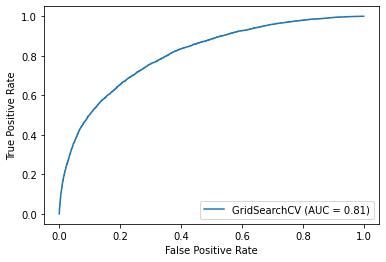

0.4344416027280477
5096
13899
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:   16.4s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   34.5s finished


[0.65496692 0.65777154 0.67645667 0.71770797 0.74732254 0.75612164
 0.75769047 0.75857635 0.75889536]
[0.6516678  0.65411283 0.67010492 0.70090445 0.71298253 0.71139017
 0.71020216 0.70941882 0.70901541]
{'C': 1}
0.7129825256288623
ROC AUC for feature LABEL_Fibrinogen  :  0.7461437502537246


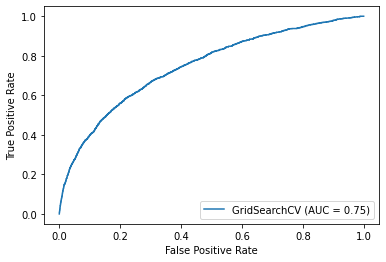

0.5293262239457102
5096
13899
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:   14.5s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   26.7s finished


[0.63637241 0.63872565 0.65322603 0.67732916 0.69480286 0.70006905
 0.70087307 0.70124553 0.7013555 ]
[0.63528618 0.63753395 0.65100773 0.67113422 0.67981933 0.67962252
 0.67895101 0.67839875 0.67812331]
{'C': 1}
0.6798193254681066
ROC AUC for feature LABEL_AST  :  0.6943659596297165


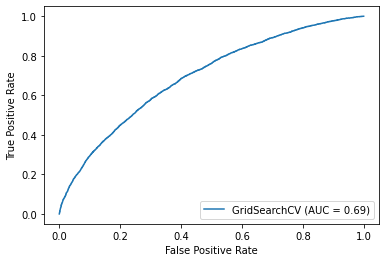

0.5268817204301075
5096
13899
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:   15.9s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   28.8s finished


[0.63852159 0.64090802 0.65557661 0.67996849 0.69778875 0.70327251
 0.70411805 0.70449926 0.7046166 ]
[0.63723627 0.63953876 0.65321135 0.6734781  0.68287262 0.68303061
 0.6824389  0.6818895  0.68157774]
{'C': 5}
0.683030613473659
ROC AUC for feature LABEL_Alkalinephos  :  0.7023392763667536


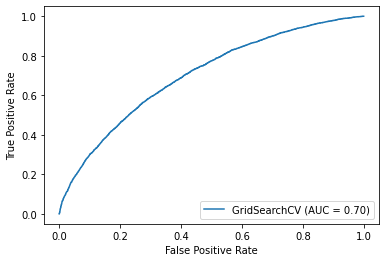

0.5299133448873483
5096
13899
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.9s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   35.6s finished


[0.63800418 0.64043499 0.65531557 0.67972849 0.69731666 0.70282727
 0.7037088  0.70411845 0.70423689]
[0.63669183 0.63899425 0.65279378 0.67287026 0.68150057 0.68169721
 0.68118393 0.68066135 0.68040348]
{'C': 5}
0.6816972072118552
ROC AUC for feature LABEL_Bilirubin_total  :  0.7018258933819765


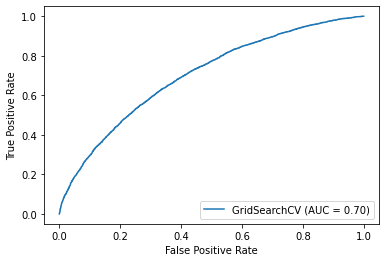

0.5031595576619273
5096
13899
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.2s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   30.2s finished


[0.68963727 0.69147209 0.70257799 0.72312617 0.74102413 0.74682424
 0.7477034  0.74809393 0.74820549]
[0.68870901 0.69046657 0.70086123 0.71778942 0.72750018 0.72746729
 0.726762   0.72607747 0.72571538]
{'C': 1}
0.7275001762213185
ROC AUC for feature LABEL_Lactate  :  0.7407502834781498


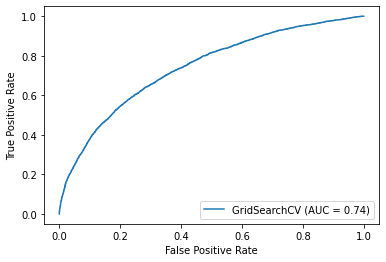

0.44701754385964915
5096
13899
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.3s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   41.8s finished


[0.6373229  0.6411379  0.66211302 0.70584393 0.74020809 0.749073
 0.75046453 0.75119048 0.75147895]
[0.63500697 0.6385271  0.65747615 0.69410571 0.71602704 0.717712
 0.71702646 0.71640748 0.7161088 ]
{'C': 5}
0.7177120009249894
ROC AUC for feature LABEL_TroponinI  :  0.7476536592139981


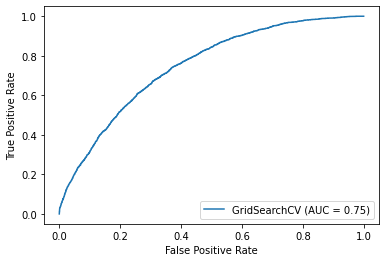

0.5251442704039572
5096
13899
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.2s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   35.3s finished


[0.71646197 0.71922804 0.73349228 0.75490544 0.77194783 0.77720935
 0.77793697 0.77821957 0.77828692]
[0.71571299 0.71840234 0.73199351 0.75047713 0.76146218 0.76244426
 0.76185276 0.76127092 0.76094913]
{'C': 5}
0.7624442588063475
ROC AUC for feature LABEL_SaO2  :  0.7765164789769364


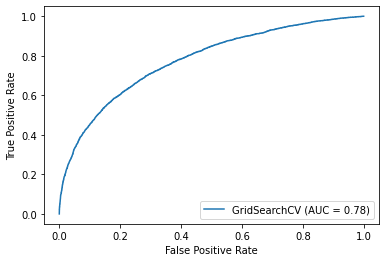

0.416544057544548
5096
13899
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   32.5s finished


[0.66234536 0.66539827 0.68572067 0.7277332  0.76185273 0.77429242
 0.77638169 0.77728734 0.77749912]
[0.65679987 0.65918027 0.6738007  0.69577404 0.69433258 0.68471564
 0.68102672 0.67809565 0.67658938]
{'C': 0.1}
0.6957740369060944
ROC AUC for feature LABEL_Bilirubin_direct  :  0.7272039264704041


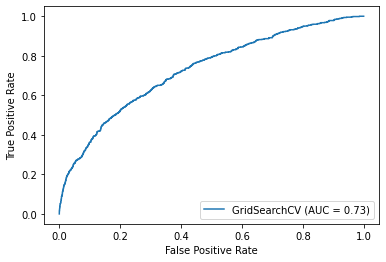

0.4308663547714334
5096
13899
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   30.4s finished


[0.69891234 0.70321065 0.72658173 0.77600882 0.81334384 0.82565024
 0.82781916 0.82878095 0.82901464]
[0.69447421 0.69848372 0.72005373 0.76253272 0.78720485 0.79167701
 0.79144191 0.79074931 0.79027259]
{'C': 5}
0.791677006175346
ROC AUC for feature LABEL_EtCO2  :  0.8244259258709877


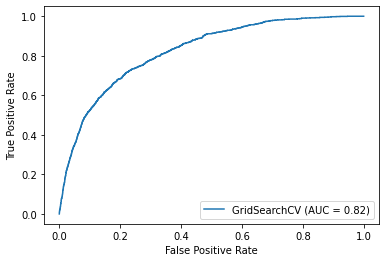

0.42687217289328194
5096
13899
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:   14.7s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   29.9s finished


[0.632818   0.6349879  0.65011733 0.68417967 0.71151705 0.72159185
 0.72349264 0.72441173 0.72469099]
[0.62866275 0.63036804 0.64144717 0.66075366 0.6626151  0.65813315
 0.65619782 0.65481251 0.65414014]
{'C': 1}
0.6626150983137691
ROC AUC for feature LABEL_Sepsis  :  0.7095356235977386


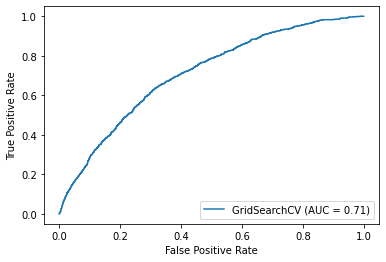

In [122]:
# first for the labels that have an output [0,1]
columns_1 = [test_pids]

from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import plot_roc_curve

for i in range(1, 12):
    #     feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_classif, mode ='k_best', param = 40)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)

    feature_map_nystroem = Nystroem(kernel = 'rbf',
                                 random_state=1,
                                 n_components=200)
    
    train_transformed = feature_map_nystroem.fit_transform(data_train_scaled)
    test_transformed = feature_map_nystroem.transform(data_test_scaled)
    
    weights = data_train.shape[0] / (2 * np.bincount(df_train_labels.iloc[:,i]))
    class_1_multiplier = 2
    print(np.sum(class_1))
    print(np.sum(class_0))
    clf_w = LogisticRegression(penalty = 'l2', class_weight = {0:weights[0], 1:(class_1_multiplier*weights[1])},
                                                               fit_intercept= True, max_iter=10000)
    
    # checked before
    #parameters = {'alpha':(0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 30)}
    parameters = {'C':(0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 30)}
    
    skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1)
    
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = skf,
                                        refit = True, scoring = 'roc_auc', verbose = 1,
                                       n_jobs=6, return_train_score = True)
    clf.fit(train_transformed, df_train_labels.iloc[:,i])
    
    print(clf.cv_results_['mean_train_score'])
    print(clf.cv_results_['mean_test_score'])
    print(clf.best_params_)
    print(clf.best_score_)
#     print("Class weightt is ", clf_w.class_weight_)
 
    probability_tmp = clf.predict_proba(test_transformed)
    probability = [item[1] for item in probability_tmp]
    columns_1.append(probability)

    probability_tmp = clf.predict_proba(train_transformed)
    probability_train = [item[1] for item in probability_tmp]
    tmp = roc_auc_score(y_score= probability_train, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    
    svc_disp = plot_roc_curve(clf, train_transformed, df_train_labels.iloc[:,i])
    plt.show()

# Compute the kernel and use SGD Classifier and Regressor

In [116]:
# first for the labels that have an output [0,1]
columns_1 = [test_pids]

# from sklearn.kernel_ridge import KernelRidge
from sklearn.kernel_approximation import Nystroem
from sklearn import linear_model


for i in range(1, 12):
   
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_classif, mode ='k_best', param=70)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    print("For feature ", df_train_labels.columns[i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)

    
    feature_map_nystroem = Nystroem(kernel = 'rbf',
                                 random_state=1,
                                 n_components=300)
    train_transformed = feature_map_nystroem.fit_transform(train_features)
    test_transformed = feature_map_nystroem.transform(test_features)
    
    clf_w = linear_model.SGDClassifier(max_iter=100000, tol=1e-4, penalty = "l2", 
                                       loss = "epsilon_insensitive", class_weight={0:1, 1:500})
    # checked before
    #parameters = {'alpha':(0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 30)}
    parameters = {'alpha':(0.1, 1, 5, 10)}
    
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 10,
                                        refit = True, scoring = 'roc_auc', verbose = 1,
                                       n_jobs=6, return_train_score = True)
    clf.fit(train_transformed, df_train_labels.iloc[:,i])
    
#     print(clf.cv_results_)
    print(clf.best_params_)
    print(clf.best_score_)
    # compute probabilites as opposed to predictions
    #dual_coefficients = clf.dual_coef_    # do we have to normalize with norm of this vector ?
    
    distance_hyperplane = clf.decision_function(test_transformed)
    probability = np.empty(len(distance_hyperplane))
    for j in range(0, len(probability)):
        if distance_hyperplane[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplane[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplane[j]))
    columns_1.append(probability)

    
    distance_hyperplace_train = clf.decision_function(train_transformed)
    probability = np.empty(len(distance_hyperplace_train))
    for j in range(0, len(probability)):
        if distance_hyperplace_train[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplace_train[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplace_train[j]))
    
    tmp = roc_auc_score(y_score= probability, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    

For feature  LABEL_BaseExcess
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

In [ ]:
# labels that have a real value
columns_2 = []

for i in range(12, 16):
#     feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param = 40)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)
    
    feature_map_nystroem = Nystroem(kernel = 'rbf',
                                 random_state=1,
                                 n_components=200)
    train_features = feature_map_nystroem.fit_transform(train_features)
    test_features = feature_map_nystroem.transform(test_features)
    
    clf_w = linear_model.SGDRegressor(max_iter=100000, tol=1e-4,
                                     loss = 'epsilon_insensitive', penalty = 'l2')
    parameters = {'alpha':(0.0001, 0.001, 0.01, 0.1, 1, 5, 10)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 10,
                                       refit = True, scoring = 'r2', verbose = 1, n_jobs=6, return_train_score=True)
#     clf = KernelRidge(kernel = 'poly', degree = 5)
#     parameters = {'alpha':(0.1,1,10,30)}
#     clf = model_selection.GridSearchCV(estimator= clf, param_grid = parameters, cv = 3,
#                                       refit = True, scoring = 'r2', verbose = 2, n_jobs=6)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    
#     print(clf.cv_results_)
    print(clf.cv_results_['mean_train_score'])
    print(clf.cv_results_['mean_test_score'])
    print(clf.best_params_)
    print(clf.best_score_)
    
    pred = clf.predict(test_features)
    columns_2.append(pred) 

    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
   

In [161]:
columns_final = columns_1 + columns_2

# XGBoosting

The benefit of XGBoost is that it accepts missing values.

In [163]:
import xgboost as xgb
# simple example
# load file from text file, also binary buffer generated by xgboost

# scale test data
min_max_scaler = preprocessing.StandardScaler()
df_train_scaled_xgboost = min_max_scaler.fit_transform(df_train_agg_features)
min_max_scaler = preprocessing.StandardScaler()
df_test_scaled_xgboost = min_max_scaler.fit_transform(df_test_agg_features)

dtrain = xgb.DMatrix(df_train_scaled_xgboost, label=df_train_labels.iloc[:,1])
dtest = xgb.DMatrix(df_test_scaled_xgboost)

In [ ]:
param = {'eta': 1, 'objective': 'binary:logistic', 'verbosity':1}
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist = [(dtrain, 'train')]

In [ ]:
num_round = 10
xgb.cv(param, dtrain, num_round, nfold=10,
       metrics={'auc'}, seed=0,
       callbacks=[xgb.callback.print_evaluation(show_stdv=True)])
# bst = xgb.train(param, dtrain, num_round)
# pred = bst.predict(dtest)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.kernel_approximation import Nystroem

columns_1 = [test_pids]


for i in range(1,12):

    clf = xgb.XGBClassifier('binary:logistic')
    
    clf_w = model_selection.GridSearchCV(estimator= clf, param_grid = {'max_depth': [2,3,4,5]}, cv = 10,
                                        refit = True, scoring = 'roc_auc', verbose = 1,
                                       n_jobs=6, return_train_score = True)
    

    clf_w.fit(df_train_scaled_xgboost, df_train_labels.iloc[:,i])
    print(clf_w.best_params_)
    print(clf_w.best_score_) 
#     dtrain = xgb.DMatrix(df_train_agg_features, label=df_train_labels.iloc[:,i])
#     num_round = 10
#     xgb.cv(param, dtrain, num_round, nfold=10,
#        metrics={'auc'}, seed=0,
#        callbacks=[xgb.callback.print_evaluation(show_stdv=True)])
    
    probability = clf_w.predict(df_test_scaled_xgboost)
    columns_1.append(probability)

    probability_train = clf_w.predict(df_train_scaled_xgboost)
#     probability_train = [item[1] for item in probability_tmp]
    tmp = roc_auc_score(y_score= probability_train, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:  1.7min finished


{'max_depth': 3}
0.9274783568945348
ROC AUC for feature LABEL_BaseExcess  :  0.8779255899507357
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:  1.7min finished


{'max_depth': 2}
0.8017052966930738
ROC AUC for feature LABEL_Fibrinogen  :  0.6419432265659888
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


In [164]:
columns_2_1 = []
param = {'max_depth': 2, 'eta': 1, 'objective': 'reg:squarederror', 'verbosity':1}
param['nthread'] = 4
param['eval_metric'] = 'rmse'
# evallist = [(dtrain, 'train')]

train_features = data_train_scaled
test_features = data_test_scaled
for i in range(12,16):
#     transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param=80)
#     train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
# #     print(list(data_train_scaled)[transformer.get_support()])
#     test_features = transformer.transform(data_test_scaled)
    
    clf_w = xgb.XGBRegressor(feval = r2_score, verbosity = 0)
            
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = {'max_depth':(3,4,5)}, cv = 10,
                                       refit = True, verbose = 1, scoring='r2',
                                       n_jobs=6, return_train_score = True)
    
    clf.fit(df_train_scaled_xgboost, df_train_labels.iloc[:,i])
    print(clf.best_params_)
    print(clf.best_score_)    
    
#     dtrain = xgb.DMatrix(df_train_scaled_xgboost, label=df_train_labels.iloc[:,i])
#     num_round = 10
    
    probability = clf.predict(df_test_scaled_xgboost)
    columns_2_1.append(probability)

    pred_train = clf.predict(df_train_scaled_xgboost)
#     probability_train = [item[1] for item in probability_tmp]
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
   

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:  1.6min finished


{'max_depth': 3}
0.4024408119294852
R2 for feature LABEL_RRate  :  0.5339601114737615
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:  1.6min finished


{'max_depth': 3}
0.6030995483696787
R2 for feature LABEL_ABPm  :  0.6833183189191033
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:  1.5min finished


{'max_depth': 4}
0.31282149409352555
R2 for feature LABEL_SpO2  :  0.6756105677316524
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:  1.6min finished


{'max_depth': 3}
0.6305290492575178
R2 for feature LABEL_Heartrate  :  0.7045131774351334


In [20]:
columns_final = columns_1 + columns_2_1

## Save predictions

In [162]:
print(np.shape(columns_final))
result = pd.DataFrame(columns_final).transpose()
result.columns = list(df_train_labels)
result.to_csv('./Results/prediction.csv.zip', index=False, float_format='%.3f', compression='zip')

(16, 12664)


In [ ]:
result.to_csv('./Results/prediction.csv', index=False, float_format='%.3f')